<a href="https://colab.research.google.com/github/chrismw44/bird-identification-ml/blob/main/Chris_White_2212349_Bird_Identification_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image


## Data Pre-Processing


Explore the dataset

In [ ]:
# Import the csv file and store as pandas dataframe
bird_df = pd.read_csv("drive/MyDrive/WLV Uni/Data Science Module/Bird Identification/Kaggle Bird Dataset/birds.csv")
print(bird_df.describe())
print("\n")
print(bird_df.head())

        class index
count  62388.000000
mean     200.362105
std      116.121431
min        0.000000
25%      100.000000
50%      201.000000
75%      302.000000
max      399.000000


   class index                      filepaths           labels data set
0            0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train
1            0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train
2            0  train/ABBOTTS BABBLER/003.jpg  ABBOTTS BABBLER    train
3            0  train/ABBOTTS BABBLER/004.jpg  ABBOTTS BABBLER    train
4            0  train/ABBOTTS BABBLER/005.jpg  ABBOTTS BABBLER    train


In [ ]:
bird_df["data set"].value_counts()

train    58388
test      2000
valid     2000
Name: data set, dtype: int64

This shows the csv file of labels contains the correct number of labels, as there are 62,388 rows of data. The csv file contains the image filepaths, species names and whether the label is for the train, test or validation data.

The dataframe of labels will be split into train, test and validation labels dataframes

In [ ]:
train_df = bird_df.loc[bird_df["data set"] == "train"]
test_df = bird_df.loc[bird_df["data set"] == "test"]
valid_df = bird_df.loc[bird_df["data set"] == "valid"]
print(train_df.head(2))
print(test_df.head(2))
print(valid_df.head(2))

   class index                      filepaths           labels data set
0            0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train
1            0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train
       class index                   filepaths           labels data set
58388            0  test/ABBOTTS BABBLER/1.jpg  ABBOTTS BABBLER     test
58389            0  test/ABBOTTS BABBLER/2.jpg  ABBOTTS BABBLER     test
       class index                    filepaths           labels data set
60388            0  valid/ABBOTTS BABBLER/1.jpg  ABBOTTS BABBLER    valid
60389            0  valid/ABBOTTS BABBLER/2.jpg  ABBOTTS BABBLER    valid


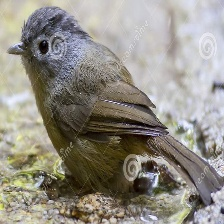

In [ ]:
# View an image
Image("drive/MyDrive/WLV Uni/Data Science Module/Bird Identification/Kaggle Bird Dataset/train/ABBOTTS BABBLER/001.jpg")

The images are stored in a google drive folder, so we will create lists of these filepaths for the train, test and validation sets.

In [ ]:
train_fnames = ["drive/MyDrive/WLV Uni/Data Science Module/Bird Identification/Kaggle Bird Dataset/" + fname for fname in train_df["filepaths"]]
test_fnames = ["drive/MyDrive/WLV Uni/Data Science Module/Bird Identification/Kaggle Bird Dataset/" + fname for fname in test_df["filepaths"]]
valid_fnames = ["drive/MyDrive/WLV Uni/Data Science Module/Bird Identification/Kaggle Bird Dataset/" + fname for fname in valid_df["filepaths"]]

In [ ]:
# Check some examples
train_fnames[:3]

['drive/MyDrive/WLV Uni/Data Science Module/Bird Identification/Kaggle Bird Dataset/train/ABBOTTS BABBLER/001.jpg',
 'drive/MyDrive/WLV Uni/Data Science Module/Bird Identification/Kaggle Bird Dataset/train/ABBOTTS BABBLER/002.jpg',
 'drive/MyDrive/WLV Uni/Data Science Module/Bird Identification/Kaggle Bird Dataset/train/ABBOTTS BABBLER/003.jpg']

In [ ]:
# Turn the labels into a numpy array
train_labels = train_df["labels"].to_numpy()
test_labels = test_df["labels"].to_numpy()
valid_labels = valid_df["labels"].to_numpy()

In [ ]:
valid_labels

array(['ABBOTTS BABBLER', 'ABBOTTS BABBLER', 'ABBOTTS BABBLER', ...,
       'YELLOW HEADED BLACKBIRD', 'YELLOW HEADED BLACKBIRD',
       'YELLOW HEADED BLACKBIRD'], dtype=object)

In [ ]:
# Find and store the number of classes (number of bird species)
num_classes = np.unique(train_labels)
len(num_classes)

400

In [ ]:
# The labels will be turned into boolean arrays
train_lab_bools = [train_label == num_classes for train_label in train_labels]
test_lab_bools = [test_label == num_classes for test_label in test_labels]
valid_lab_bools = [valid_label == num_classes for valid_label in valid_labels]

In [ ]:
train_lab_bools[:1]

[array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [ ]:
# A function for turning images into tensors
img_size = 224

"""
This function converts the jpegs to numerical tensors with 3 colour channels,
normalizes these colour values, then ensures the image is the specified size.
"""
def image_to_tensor(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[img_size, img_size])
  return image

### To use TensorFlow, our Tensors need to be tuples in the form (image, label)

In [ ]:
# Function to create Tensor tuples
def tensor_tuples(image_path, label):
  image = image_to_tensor(image_path)
  return image, label

In [ ]:
# Function to create batches of data
batch_size = 32

# Function will turn image and label data into batches.
# Data will be shuffled if it is training data.
def data_batches(X, y, batch_size=batch_size, valid_data=False, test_data=False):
  if test_data:
    print("Test data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(tensor_tuples).batch(batch_size)
    return data_batch

  elif valid_data:
    print("Valid data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(tensor_tuples).batch(batch_size)
    return data_batch

  else:
    print("Training data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(tensor_tuples).batch(batch_size)
    return data_batch


### To reduce experimentation time, a smaller sample of 2000 images taken from the training images, will be split into training/validation data to be used.

In [ ]:
X = train_fnames
y = train_lab_bools

X_train, X_val, y_train, y_val = train_test_split(X[:2000],
                                                  y[:2000],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(1600, 1600, 400, 400)

In [ ]:
# Turn the training and validation data to batches
train_batches = data_batches(X_train, y_train)
val_batches = data_batches(X_val, y_val, valid_data=True)

Training data batches
Valid data batches


In [ ]:
train_batches.element_spec, val_batches.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 400), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 400), dtype=tf.bool, name=None)))

## Building the model

In [ ]:
# Define input and output shapes
input_shape = [None, img_size, img_size, 3]
output_shape = len(num_classes)


Transfer learning is being used. The model to be used is from TensorFlow Hub and we need to provide the URL.

In [ ]:
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [ ]:
# A function to create a Keras model
def build_model(input_shape=input_shape, output_shape=output_shape, model_url=model_url):
  model = tf.keras.Sequential([hub.KerasLayer(model_url),
                               tf.keras.layers.Dense(units=output_shape,
                                                     activation="softmax")])

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

  model.build(input_shape)

  return model



In [ ]:
model = build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 400)               400800    
                                                                 
Total params: 5,833,513
Trainable params: 400,800
Non-trainable params: 5,432,713
_________________________________________________________________
None


## Callback for early stopping

In [ ]:
# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              patience=3)

In [ ]:
# Function to train a model
num_epochs = 100

def train_model():
  model = build_model()
  model.fit(x=train_batches,
                      verbose=1,
                      epochs=num_epochs,
                      validation_data=val_batches,
                      validation_freq=1,
                      callbacks=[early_stop])
  return model

In [ ]:
model = train_model()

Epoch 1/100
50/50 [==============================] - 13s 133ms/step - loss: 1.3840 - accuracy: 0.7150 - val_loss: 0.3293 - val_accuracy: 0.9325
Epoch 2/100
50/50 [==============================] - 6s 121ms/step - loss: 0.1690 - accuracy: 0.9581 - val_loss: 0.2511 - val_accuracy: 0.9425
Epoch 3/100
50/50 [==============================] - 6s 119ms/step - loss: 0.0994 - accuracy: 0.9806 - val_loss: 0.2156 - val_accuracy: 0.9450
Epoch 4/100
50/50 [==============================] - 6s 119ms/step - loss: 0.0693 - accuracy: 0.9919 - val_loss: 0.1994 - val_accuracy: 0.9475
Epoch 5/100
50/50 [==============================] - 6s 121ms/step - loss: 0.0509 - accuracy: 0.9956 - val_loss: 0.1951 - val_accuracy: 0.9500
Epoch 6/100
50/50 [==============================] - 6s 120ms/step - loss: 0.0399 - accuracy: 0.9987 - val_loss: 0.1854 - val_accuracy: 0.9500
Epoch 7/100
50/50 [==============================] - 45s 925ms/step - loss: 0.0329 - accuracy: 0.9987 - val_loss: 0.1858 - val_accuracy: 0.95

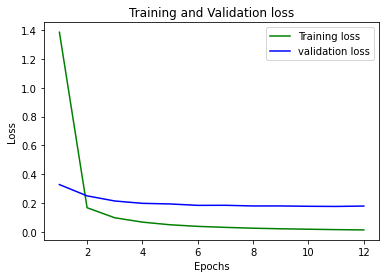

In [ ]:
loss_train = model.history.history['loss']
loss_val = model.history.history['val_loss']
epochs = range(1,13)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

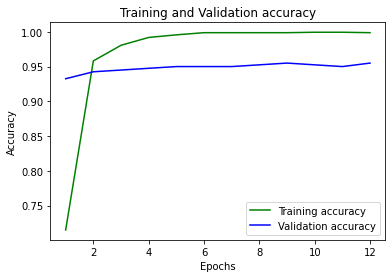

In [ ]:
acc_train = model.history.history['accuracy']
acc_val = model.history.history['val_accuracy']
epochs = range(1,13)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The model performed well on the small sample of data, with a validation loss of 0.1806 and validation accuracy of 95.5%.

The full data will now be passed to the model. The training data of 58,388 images/labels and validation data of 2000 images/labels.

In [ ]:
len(X), len(y)

(58388, 58388)

In [ ]:
X_train_full = train_fnames
y_train_full = train_lab_bools
X_val_full = valid_fnames
y_val_full = valid_lab_bools

len(X_train_full), len(y_train_full), len(X_val_full), len(y_val_full)

(58388, 58388, 2000, 2000)

In [ ]:
train_batches_full = data_batches(X_train_full, y_train_full)
val_batches_full = data_batches(X_val_full, y_val_full, valid_data=True)

Training data batches
Valid data batches


In [ ]:
train_batches_full

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400), dtype=tf.bool, name=None))>

In [ ]:
val_batches_full

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400), dtype=tf.bool, name=None))>

In [ ]:
full_data_model = build_model()

In [ ]:
print(full_data_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_4 (Dense)             (None, 400)               400800    
                                                                 
Total params: 5,833,513
Trainable params: 400,800
Non-trainable params: 5,432,713
_________________________________________________________________
None


In [ ]:
# Create early stopping callback
full_model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                         patience=3)

In [ ]:
full_data_model.fit(x=train_batches_full,
               verbose=1,
               epochs=num_epochs,
               validation_data=val_batches_full,
               validation_freq=1,
               callbacks=[full_model_early_stop])

Epoch 1/100
1825/1825 [==============================] - 16765s 9s/step - loss: 0.9575 - accuracy: 0.7907 - val_loss: 0.2734 - val_accuracy: 0.9250
Epoch 2/100
1825/1825 [==============================] - 186s 102ms/step - loss: 0.2877 - accuracy: 0.9242 - val_loss: 0.2403 - val_accuracy: 0.9350
Epoch 3/100
1825/1825 [==============================] - 180s 98ms/step - loss: 0.1784 - accuracy: 0.9517 - val_loss: 0.2255 - val_accuracy: 0.9295
Epoch 4/100
1825/1825 [==============================] - 180s 99ms/step - loss: 0.1239 - accuracy: 0.9654 - val_loss: 0.2266 - val_accuracy: 0.9360
Epoch 5/100
1825/1825 [==============================] - 216s 118ms/step - loss: 0.0892 - accuracy: 0.9755 - val_loss: 0.2378 - val_accuracy: 0.9330
Epoch 6/100
1825/1825 [==============================] - 183s 100ms/step - loss: 0.0679 - accuracy: 0.9812 - val_loss: 0.2246 - val_accuracy: 0.9425
Epoch 7/100
1825/1825 [==============================] - 183s 100ms/step - loss: 0.0534 - accuracy: 0.9844 - 

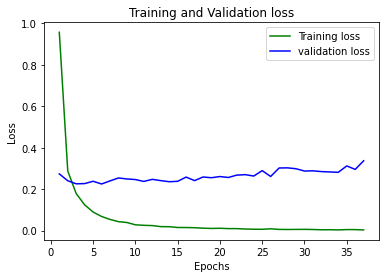

In [ ]:
loss_train = full_data_model.history.history['loss']
loss_val = full_data_model.history.history['val_loss']
epochs = range(1,38)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

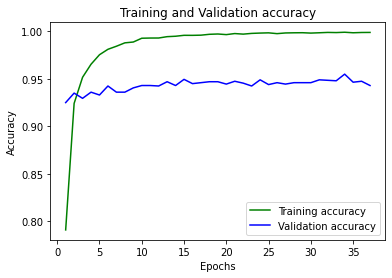

In [ ]:
acc_train = full_data_model.history.history['accuracy']
acc_val = full_data_model.history.history['val_accuracy']
epochs = range(1,38)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
full_data_model.history.history

{'accuracy': [0.7907446622848511,
  0.9241625070571899,
  0.9517024159431458,
  0.9654381275177002,
  0.9754573106765747,
  0.981194794178009,
  0.9844145774841309,
  0.9879941344261169,
  0.9888675808906555,
  0.9928581118583679,
  0.9930636286735535,
  0.9930979013442993,
  0.9945194125175476,
  0.9949647188186646,
  0.9959409236907959,
  0.9959067106246948,
  0.9960950613021851,
  0.9970027804374695,
  0.9973282217979431,
  0.9966773986816406,
  0.9977906346321106,
  0.9971911907196045,
  0.9979619383811951,
  0.9983044266700745,
  0.9985442161560059,
  0.9977049827575684,
  0.9984243512153625,
  0.9985955953598022,
  0.9986812472343445,
  0.9982873201370239,
  0.9986298680305481,
  0.9989895224571228,
  0.9988353848457336,
  0.9991779327392578,
  0.9986298680305481,
  0.9989210367202759,
  0.9989895224571228],
 'loss': [0.957511842250824,
  0.28773656487464905,
  0.17835739254951477,
  0.12385367602109909,
  0.08921395987272263,
  0.06786592304706573,
  0.0533999539911747,
  0.0427

In [ ]:
X_test_full = test_fnames
y_test_full = test_lab_bools

len(X_test_full), len(y_test_full)

(2000, 2000)

In [ ]:
test_batches_full = data_batches(X_test_full, y_test_full, test_data=True)

Test data batches


In [ ]:
evaluation = full_data_model.evaluate(test_batches_full, verbose=1)

63/63 [==============================] - 8s 130ms/step - loss: 0.1825 - accuracy: 0.9590


### Test Data results
* Accuracy: 95.90%
* Loss: 0.1825

In [ ]:
predictions = full_data_model.predict(test_batches_full, verbose=1)
predictions

63/63 [==============================] - 8s 119ms/step


array([[1.00e+00, 7.91e-13, 1.25e-19, ..., 1.07e-12, 1.28e-17, 3.63e-25],
       [8.55e-01, 1.91e-14, 5.86e-26, ..., 6.48e-10, 1.33e-15, 1.83e-30],
       [1.00e+00, 2.26e-18, 9.46e-25, ..., 5.40e-05, 4.41e-18, 3.65e-33],
       ...,
       [9.53e-27, 1.47e-19, 2.51e-22, ..., 1.34e-12, 6.58e-20, 1.00e+00],
       [7.59e-12, 1.57e-14, 5.33e-22, ..., 4.48e-07, 7.90e-18, 9.93e-01],
       [8.54e-29, 8.19e-20, 3.25e-19, ..., 6.58e-17, 2.08e-16, 1.00e+00]],
      dtype=float32)

In [ ]:
predictions.shape

(2000, 400)

In [ ]:
def get_label(prediction_probabilities):
  return num_classes[np.argmax(prediction_probabilities)]

In [ ]:
test_batches_full

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400), dtype=tf.bool, name=None))>

In [ ]:
def unbatch_data(data):

  images = []
  labels = []

  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(num_classes[np.argmax(label)])
  return images, labels

test_images, test_labels = unbatch_data(test_batches_full)
test_images[0], test_labels[0]

(array([[[0.14, 0.02, 0.02],
         [0.11, 0.  , 0.  ],
         [0.11, 0.01, 0.  ],
         ...,
         [0.23, 0.28, 0.22],
         [0.29, 0.35, 0.29],
         [0.34, 0.4 , 0.35]],
 
        [[0.13, 0.01, 0.  ],
         [0.12, 0.01, 0.  ],
         [0.11, 0.02, 0.  ],
         ...,
         [0.18, 0.23, 0.18],
         [0.24, 0.29, 0.24],
         [0.3 , 0.36, 0.31]],
 
        [[0.16, 0.04, 0.03],
         [0.15, 0.04, 0.02],
         [0.13, 0.04, 0.02],
         ...,
         [0.15, 0.2 , 0.16],
         [0.21, 0.27, 0.23],
         [0.28, 0.34, 0.3 ]],
 
        ...,
 
        [[0.  , 0.01, 0.  ],
         [0.  , 0.01, 0.  ],
         [0.  , 0.  , 0.  ],
         ...,
         [0.14, 0.25, 0.01],
         [0.14, 0.25, 0.01],
         [0.13, 0.24, 0.  ]],
 
        [[0.  , 0.01, 0.  ],
         [0.  , 0.01, 0.  ],
         [0.  , 0.  , 0.  ],
         ...,
         [0.14, 0.24, 0.01],
         [0.13, 0.24, 0.  ],
         [0.12, 0.23, 0.  ]],
 
        [[0.  , 0.01, 0.  ],
 

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  pred_label = get_label(pred_prob)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title("Predicted: {} {:2.2f}% \n Truth: {}".format(pred_label,
                                 np.max(pred_prob)*100,
                                 true_label))

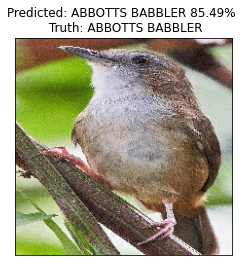

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=test_labels,
          images=test_images)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  pred_prob, true_label = prediction_probabilities[n], labels[n]
  pred_label = get_label(pred_prob)

  top_5_pred_indexes = pred_prob.argsort()[-5:][::-1]
  top_5_pred_values = pred_prob[top_5_pred_indexes]
  top_5_pred_labels = num_classes[top_5_pred_indexes]

  top_plot = plt.bar(np.arange(len(top_5_pred_labels)),
                     top_5_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_5_pred_labels)),
             labels=top_5_pred_labels,
             rotation="vertical")

  if np.isin(true_label, top_5_pred_labels):
    top_plot[np.argmax(top_5_pred_labels == true_label)].set_color("green")
  else:
    pass



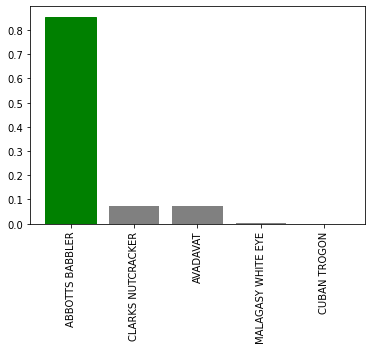

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=test_labels,
               n=1)

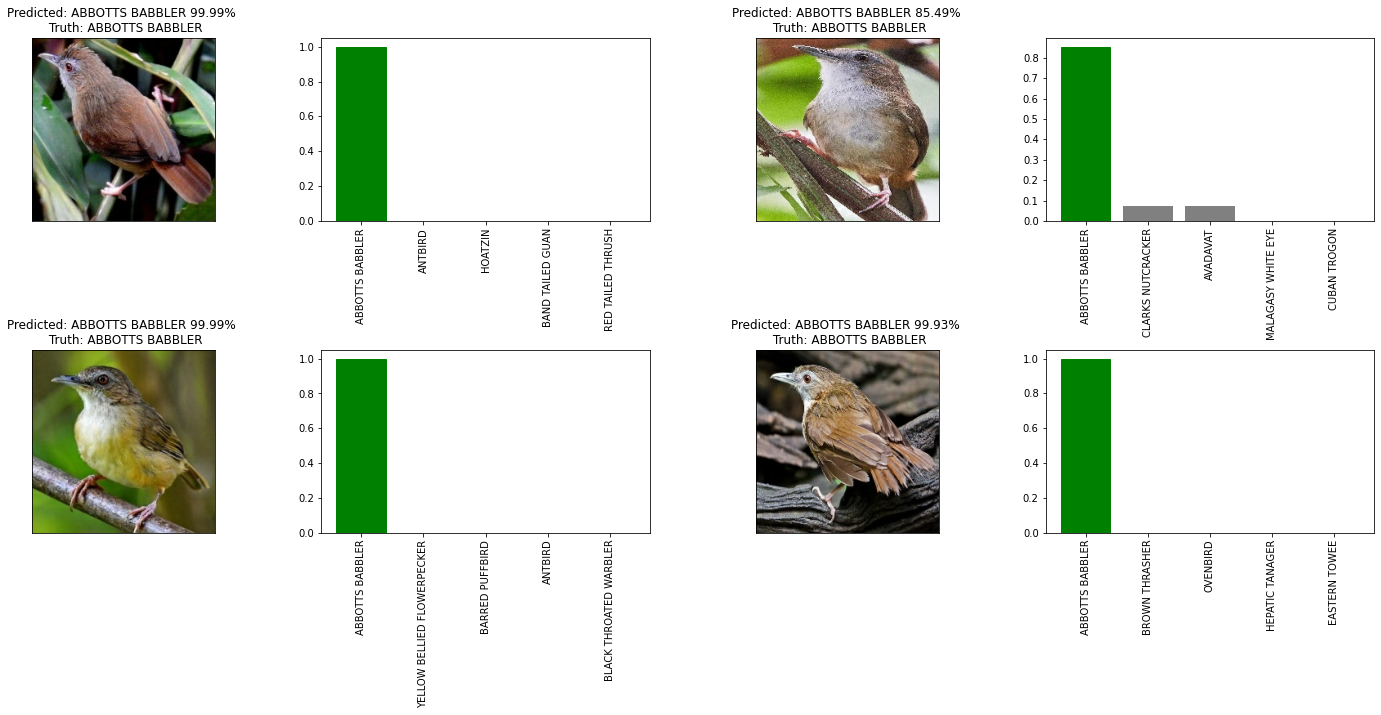

In [ ]:
i_multiplier = 0
num_rows = 2
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=test_labels,
            images=test_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=test_labels,
                 n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_preds = np.array([get_label(p) for p in predictions])

print('Classification Report')
print(classification_report(test_labels, y_preds))


Classification Report
                             precision    recall  f1-score   support

            ABBOTTS BABBLER       1.00      0.50      0.67        10
              ABBOTTS BOOBY       0.71      1.00      0.83         5
 ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
      AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
     AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
          AFRICAN FIREFINCH       1.00      1.00      1.00         5
     AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
                  ALBATROSS       1.00      1.00      1.00         5
             ALBERTS TOWHEE       1.00      0.80      0.89         5
       ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
              ALPINE CHOUGH       1.00      0.60      0.75         5
      ALTAMIRA YELLOWTHROAT       1.00      0.60      0.75         5
            AMERICAN AVOCET       1.00      1.00      1.00         5
           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
